In [95]:
%matplotlib inline

Single-subject example: extract network activation features to feed an SVM model

**Note: using the 20 networks parcellation for now**
MIST parcellation references:
https://mniopenresearch.org/articles/1-3/v2#ref-50
https://figshare.com/articles/MIST_A_multi-resolution_parcellation_of_functional_networks/5633638/1

**Normalized to ICBM2009 atlas**
ICBM 152: http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009


In [96]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import scipy
import nibabel

from numpy import nan as NaN
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_img, show
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn.connectome import ConnectivityMeasure


#libraries need to be installed in conda environment with pip install

Step 1. Load files

(53, 64, 52, 78)
(3.0, 3.0, 3.0, 1.0)
(53, 64, 52, 117)
(3.0, 3.0, 3.0, 1.0)


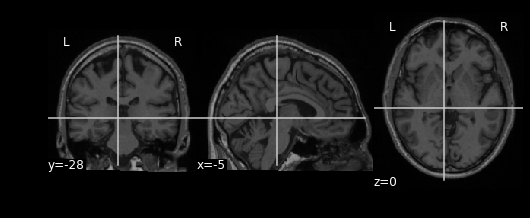

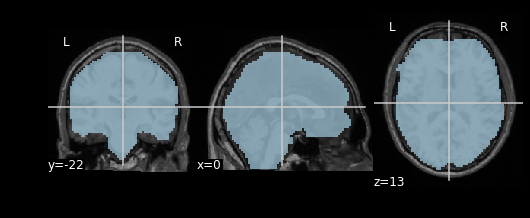

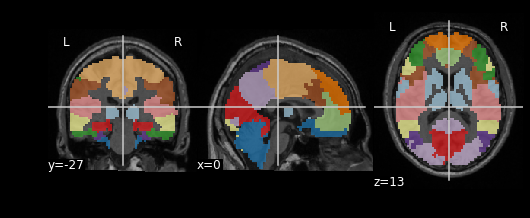

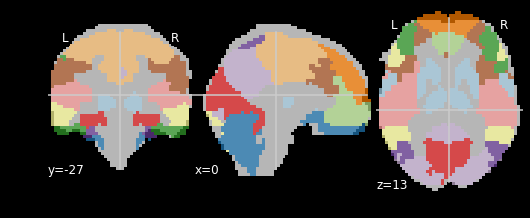

In [97]:
#subject id
id = '122922'

#load beta maps
#create a 4D file that includes all 3D beta weight images (78 images), in ascending order 
#note: glob.glob does not garanty order of frames, recommended to use Nilearn's load_img
#beta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/SingleModel'
betas_enc = image.load_img(img='/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/SingleModel/betas*nii', 
                              wildcards=True)
betas_all = image.load_img(img='/Users/mombot/Documents/Simexp/CIMAQ/Data/test/Output2/Output/122922/MultiModels/betas*.nii',
                           wildcards=True)

print(betas_enc.header.get_data_shape()) #shape of 4D betas map image object
print(betas_enc.header.get_zooms()) #voxel sizes in mm

print(betas_all.header.get_data_shape()) #shape of 4D betas map image object
print(betas_all.header.get_zooms()) #voxel sizes in mm

#load fMRI data (310 epi frames in a single 4D file)
fmri_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/fMRI'
fmri = glob.glob(os.path.join(fmri_dir, 'fmri_sub'+id+'*nii'))[0] #single 4D file

#load confounds to be regressed out when extracting signal from raw epis 
motion_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MotionFiles/motion_resample/fromNIAK'
confounds = glob.glob(os.path.join(motion_dir, 'fmri_sub'+id+'*confounds.tsv'))[0]
#confounds = pd.read_csv(subject_motion, sep='\t')

#load 20-networks BASC parcellation
basc_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations'
basc = os.path.join(basc_dir, 'MIST_20.nii')
#Note: bask parcellation is in "labels" format: a single 3D image with different 
#label numbers (integers) for different parcels in the same image.  
#Labels are handled by NiftiLabelsMasker:
#https://nilearn.github.io/manipulating_images/masker_objects.html

#Selecting a mask and anatomical template (for display) from images outputed by NIAK
anat_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/anat/122922'
#anats = glob.glob(os.path.join(anat_dir, '*nii'))
#for anat in anats:
#    print(anat)
#    plot_anat(anat)
    
#normalized anatomical image (non-linear)
anat = nibabel.load(os.path.join(anat_dir, 'anat_sub122922_nuc_stereonl.nii'))
plot_anat(anat)
#normalized functional MRI data mask
mask = nibabel.load(os.path.join(anat_dir, 'func_sub122922_mask_stereonl.nii'))
plotting.plot_roi(roi_img=mask, bg_img=anat, cmap='Paired')

#Show overlap between basc parcellation, functional mri mask and anatomical image
plotting.plot_roi(roi_img=basc, bg_img=anat, cmap='Paired')
plotting.plot_roi(roi_img=basc, bg_img=mask, cmap='Paired')


Step 2. Vectorize memory task epi scans (310 fMRI frames) 

Regress out confounds (.tsv file) computed with NIAK preprocessing pipeline from raw fMRI signal

Mask data with normalized functional mri mask (non-linear)

In [98]:
#use NiftiMasker object to convert epi images into a frames x voxels data matrix (310 x 69924)
masker = NiftiMasker(mask_img=mask, standardize=True)

# give the masker a filename and retrieve a 2D array
# for machine learning with scikit-learn
epi_sig = masker.fit_transform(fmri, confounds = confounds)

print(epi_sig.shape) #78 rows = trials, 69924 cols = voxels, val = beta weights

(310, 69924)


Step 3. Extract signal time series averaged within each of the MIST 20 networks 
over the 310 fMRI frames

Regress out confounds computed with NIAK preprocessing pipeline from raw fMRI signal              

In [99]:
#Uses the NiftiLabelsMasker object to vectorize each network's time series
#into a frames x networks data matrix (310 x 20)
##verify: I am using the functional mask on the fMRI data to exclude "voxels" inside the labelled
#region, but outside the participant's brain
label_masker = NiftiLabelsMasker(labels_img=basc, standardize=True, mask_img=mask, memory = 'nilearn_cache', 
                           verbose=5)

roi_sig = label_masker.fit_transform(fmri, confounds = confounds)
print(roi_sig.shape)

print(roi_sig[309:310, :])

[NiftiLabelsMasker.fit_transform] loading data from /Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations/MIST_20.nii
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('/Users/mombot/Documents/Simexp/CIMAQ/Data/anat/122922/func_sub122922_mask_stereonl.nii')
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
(310, 20)
[[-0.13850543  0.89641291  0.64156     0.29890823 -0.63384054  0.69285192
   0.77666882 -1.22923547  3.48250473 -0.99062746 -1.36988583 -1.18976565
  -1.03446056 -0.90240539  3.26844982  0.62993445  0.94079292 -0.76334733
  -1.71831772 -0.27478126]]


Step 4. Calculate a correlation matrix between the data matrices obtained in steps 2 and 3, respectively. 

The result is a network per voxel data matrix (20 x 69924) that quantifies to what extent
a voxel's signal correlates with each of the 20 networks over each fMRI frame 

In [100]:
#first test it out on 50 voxels... Get proper Pearson correlations? Normalize?
#epi = epi_sig[:, 0:2000]
epi = epi_sig
vox_correls = np.empty([20, epi.shape[1]])
print(epi.shape)
print(vox_correls.shape)

#print(pearsonr(epi[:, 0], roi_sig[:, 0])[0])
#print(np.corrcoef(epi[:, 0], roi_sig[:, 0], rowvar=False)[0, 1])

for i in range(0, 20):
    for j in range(0, epi.shape[1]):
        #vox_correls[i, j] = np.corrcoef(epi[:, j], roi_sig[:, i], rowvar=False)[0, 1]
        vox_correls[i, j] = pearsonr(epi[:, j], roi_sig[:, i])[0]

     

(310, 69924)
(20, 69924)


Step 5. Vectorize betas file using functional mask. 
Result is a trial * voxels data matric (78 * 69924)

In [101]:
#use NiftiMasker object to convert beta weights images into a trials x voxels data matrix (78 x 69924)
#masker_betas = NiftiMasker(mask_img=mask, standardize=True)

# give the masker a list of file names (3D images) and transform them into a 2D arrays
# Note: no need to regress out confounds since it was done when computing betas
betaEnc_mat = masker.fit_transform(betas_enc)
betaAll_mat = masker.fit_transform(betas_all)

print(betaEnc_mat.shape) #78 rows = encoding trials, 69924 cols = voxels, val = beta weights
print(betaAll_mat.shape) #117 rows = all trials (enc and ctl), 69924 cols = voxels, val = beta weights


(78, 69924)
(117, 69924)


Step 6. Correlate matrices from steps 4 and 5 to obtain a trial per network correlation matrix (78 x 20 for encoding trials; 117 x 20 for all trials; features to be used in SVM model training, each row is an event to be classified)

In [102]:
#first test it out on first 50 voxels... Get proper Pearson correlations? Normalize?
betaEnc = betaEnc_mat
betaAll = betaAll_mat
netmaps = vox_correls

featuresEnc = np.empty([betaEnc.shape[0], 20])
featuresAll = np.empty([betaAll.shape[0], 20])
print(betaEnc.shape)
print(betaAll.shape)
print(netmaps.shape)
print(featuresEnc.shape)
print(featuresAll.shape)

#print(pearsonr(betaEnc[0, :], netmaps[0, :])[0])

for i in range(0, betaEnc.shape[0]):
    for j in range(0, 20):
        featuresEnc[i, j] = pearsonr(betaEnc[i, :], netmaps[j, :])[0]

for k in range(0, betaAll.shape[0]):
    for m in range(0, 20):
        featuresAll[k, m] = pearsonr(betaAll[k, :], netmaps[m, :])[0]        
        
#print(featuresEnc[:, 19])  
#print(featuresEnc.shape)

##Save feature datamatrix for machine learning 

dataEnc = pd.DataFrame(data=featuresEnc)
print(dataEnc.head)
print(dataEnc.shape)

dataEnc.to_csv('/Users/mombot/Documents/Simexp/CIMAQ/Data/Nilearn/features/sub-'+str(id)+'-20networks_78EncoTrials.tsv',
    sep='\t', header=False, index=False)

dataAll = pd.DataFrame(data=featuresAll)
print(dataAll.head)
print(dataAll.shape)

dataAll.to_csv('/Users/mombot/Documents/Simexp/CIMAQ/Data/Nilearn/features/sub-'+str(id)+'-20networks_117Trials.tsv',
    sep='\t', header=False, index=False)


(78, 69924)
(117, 69924)
(20, 69924)
(78, 20)
(117, 20)
<bound method NDFrame.head of           0         1         2         3         4         5         6   \
0   0.025487 -0.037266  0.142310 -0.015759 -0.049622  0.241206 -0.135650   
1  -0.154152 -0.079414  0.265200 -0.251604 -0.153117  0.249506  0.004968   
2   0.138362 -0.078060  0.081580 -0.163760  0.287620  0.052235 -0.144224   
3  -0.089131 -0.018564  0.197475 -0.034350 -0.128577  0.217944 -0.014048   
4   0.077138 -0.153285  0.324962 -0.299730  0.084848  0.326199  0.029525   
5   0.168476  0.101339 -0.165834  0.151509  0.144296 -0.149204 -0.053967   
6   0.199800 -0.117218  0.096005 -0.091757  0.205434  0.073368  0.045992   
7  -0.257561  0.087449  0.117184  0.194542 -0.373432  0.191004  0.130365   
8   0.322202 -0.091413 -0.038878 -0.162122  0.379710 -0.063961 -0.077134   
9   0.011900  0.044568  0.020782  0.161497 -0.019169  0.043975  0.163060   
10  0.276202 -0.097895 -0.020019 -0.119578  0.178772 -0.006826 -0.052464   
11

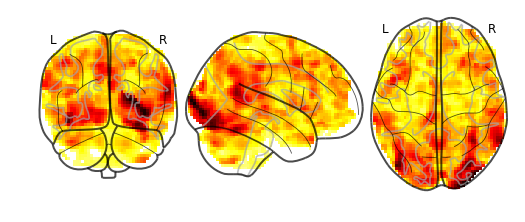

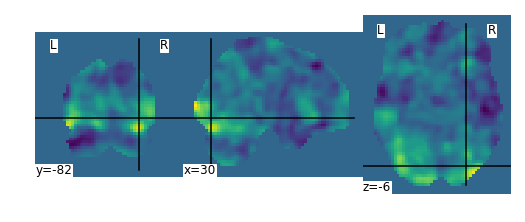

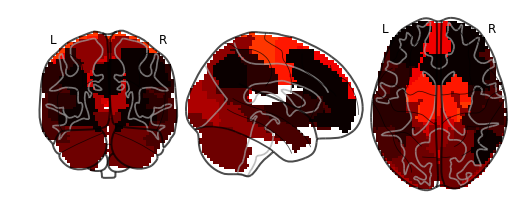

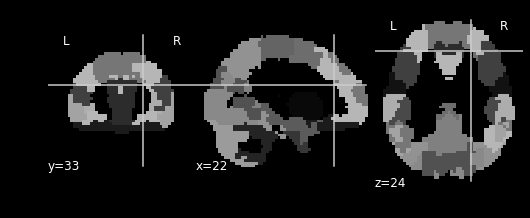

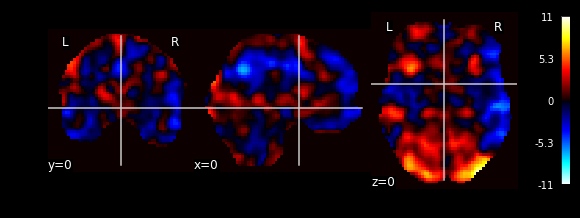

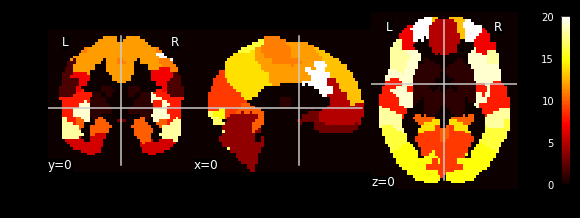

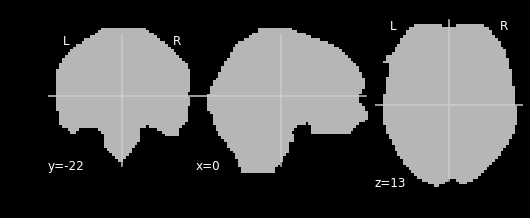

In [92]:
#Extra junk: messing around with Nilearn plotting functions

#Load fmri contrast : Encoding minus retrieval t map
tscores = '/Users/mombot/Documents/Simexp/CIMAQ/Data/test/Output/122922/MultiModels/EncMinCTL_tscores_sub122922.nii'
plotting.plot_glass_brain(tscores)

plot_img(tscores)

#plotting.plot_prob_atlas(maps_img=basc, view_type='filled_contours')

plotting.plot_glass_brain(basc)

plot_anat(basc)
plot_stat_map(stat_map_img=tscores, bg_img=mask, cut_coords=(0, 0, 0), threshold=None, colorbar=True)
plot_stat_map(stat_map_img=basc, bg_img=mask, cut_coords=(0, 0, 0), threshold=None, colorbar=True)

plot_anat(mask)

